# NLP HW 
By:
Arash Asgari, Behdad Abdollahi

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 2.7 MB/s 
     |████████████████████████████████| 101 kB 12.5 MB/s 
     |████████████████████████████████| 6.6 MB 22.0 MB/s 
     |████████████████████████████████| 596 kB 48.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Imports and Read Data

In [2]:
import json

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
with open("/content/dataset_annotated_sentiment.json") as f:
  data = json.load(f)

## Initializing Dataframes

column ***raw***: consist of not clean data.

column ***raw_label***: consist of a list of three different individuals' labels and the labels consist of منفی، خنثی and مثبت.

In [4]:
train_raw_text, train_raw_labels = [data['train'][i]['text'] for i in range(len(data['train']))], [data['train'][i]['annotations'] for i in range(len(data['train']))]
eval_raw_text, eval_raw_labels = [data['eval'][i]['text'] for i in range(len(data['eval']))], [data['eval'][i]['annotations'] for i in range(len(data['eval']))]
test_raw_text, test_raw_labels = [data['test'][i]['text'] for i in range(len(data['test']))],  [data['test'][i]['annotations'] for i in range(len(data['test']))]

train_df = pd.DataFrame({"raw": train_raw_text, "raw_label": train_raw_labels})
eval_df = pd.DataFrame({"raw": eval_raw_text, "raw_label": eval_raw_labels})
test_df = pd.DataFrame({"raw": test_raw_text, "raw_label": test_raw_labels})

## Re-annotation

Some data had annotated by 2 individuals (not 3) and among these, 52 pair labels, had been labeled differently i.e. for example one of them got labeled مثبت and the other one خنثی.

A file of this kind of data is gathered in a file to get re-annotated by us.

In [ ]:
def re_annotation_data(data_text, data_labels, group):
  reannotation_list = []
  for i in range(len(data_labels)):
    if (len(data_labels[i]) == 2 and data_labels[i][0] != data_labels[i][1]) or len(data_labels[i]) == 0:
      reannotation_list.append((data_text[i], group, i))
  return reannotation_list

def create_csv(reanno_list, name):
  reanno_text, reanno_group, reanno_ind = [sample[0] for sample in reannotation_list], [sample[1] for sample in reannotation_list], [sample[2] for sample in reannotation_list]
  reannotation_df = pd.DataFrame({"my_text": reanno_text, "group": reanno_group, "index": reanno_ind})
  reannotation_df.to_csv(name + ".csv")



reannotation_list = re_annotation_data(train_raw_text, train_raw_labels, "train") + re_annotation_data(eval_raw_text, eval_raw_labels, "eval") + re_annotation_data(test_raw_text, test_raw_labels, "test") 

first_reannotation_list = reannotation_list[:int(len(reannotation_list)/2)]
second_reannotation_list = reannotation_list[int(len(reannotation_list)/2):]
create_csv(first_reannotation_list, "arash_reanno")
create_csv(second_reannotation_list, "behdad_reanno")





In [ ]:
reanno_text, reanno_group, reanno_ind = [sample[0] for sample in reannotation_list], [sample[1] for sample in reannotation_list], [sample[2] for sample in reannotation_list]
reannotation_df = pd.DataFrame({"my_text": reanno_text, "group": reanno_group, "index": reanno_ind})
reannotation_df.to_csv("reannotation.csv")

## Data Cleaning


*   ***unknown_labels*** func: For data (row) which has no label or 2 labels with different values, ***zero*** will be returned (which means the labels is unknown), otherwise ***one*** will be returned. This function will be applied to the ***"raw_labels"*** column.
*   ***most_frequent*** func: Among the labels, the label which has more frequency will be returned.

*   ***to_sentiment*** func: Convert string labels to integer labels.




For each train_df, eval_df and test_df we first find unknow_labels with applying function ***unknown_labels*** to ***'raw_labels'*** column and create a new column named **"is_unknown"**, then we only consider the known labels (the rows which their ***is_unknown*** column is 1), afterward we consider the most frequent label from the ***raw_labels*** as the dominant label using ***most_frequent*** function and then the ***is_unknown*** label get dropped (it's not needed any more) then the labels get converted to sentiments (integer labels)

In [5]:
class_names = ['منفی','خنثی','مثبت']
def unknown_labels(label_list):
    if (len(label_list) == 2 and label_list[0] != label_list[1]) or (len(label_list) == 0):
      return 0 # label can not be known as the two annotations are different
    else:
      return 1 # label can be understood as you can assign the class with majority labels to the class
    
def most_frequent(labels):
    labels = list(labels)
    return (max(set(labels), key = labels.count))

def to_sentiment(rating):
  if rating == 'منفی':
    return 0
  elif rating == 'خنثی' :
    return 1
  else: 
    return 2

train_df["is_unknown"] = train_df["raw_label"].apply(unknown_labels)
train_df = train_df[train_df["is_unknown"] == 1]
train_df['label'] = train_df["raw_label"].apply(most_frequent)
train_df = train_df.drop(columns = ['is_unknown'])
train_df['label'] = train_df["label"].apply(to_sentiment)

eval_df["is_unknown"] = eval_df["raw_label"].apply(unknown_labels)
eval_df = eval_df[eval_df["is_unknown"] == 1]
eval_df['label'] = eval_df["raw_label"].apply(most_frequent)
eval_df = eval_df.drop(columns = ['is_unknown'])
eval_df['label'] = eval_df["label"].apply(to_sentiment)

test_df["is_unknown"] = test_df["raw_label"].apply(unknown_labels)
test_df = test_df[test_df["is_unknown"] == 1]
test_df['label'] = test_df["raw_label"].apply(most_frequent)
test_df = test_df.drop(columns = ['is_unknown'])
test_df['label'] = test_df["label"].apply(to_sentiment)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

The news had some kind of seperator between the title and the body of the news text, so we substitute this seperator which is an "endline" following with some number of "_" and another "endline", with a dot (".").

In [6]:
import re
train_df["text"] = train_df["raw"].apply(lambda x: re.sub(r"\s_+\s", ". ", x))
train_df['len'] = train_df['text'].apply(lambda x: len(x))

eval_df["text"] = eval_df["raw"].apply(lambda x: re.sub(r"\s_+\s", ". ", x))
eval_df['len'] = eval_df['text'].apply(lambda x: len(x))

test_df["text"] = test_df["raw"].apply(lambda x: re.sub(r"\s_+\s", ". ", x))
test_df['len'] = test_df['text'].apply(lambda x: len(x))

In [7]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 28.3 MB/s 
     |████████████████████████████████| 233 kB 59.4 MB/s 
     |████████████████████████████████| 1.4 MB 49.9 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394491 sha256=3b81dd160327c095de0cc7de71469d9311676114aa160ee419bcaee2265c38ba
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154044 sha256=d2fd78dc55f388b88cc24204e763a325a50358f83f084cce1d21326081ed6346
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [8]:
import re
from hazm import *
from tqdm import tqdm  
import codecs
import nltk

## Download Pars bert model and tokenizer

In [9]:
PRE_TRAINED_MODEL_NAME = 'pars-bert'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


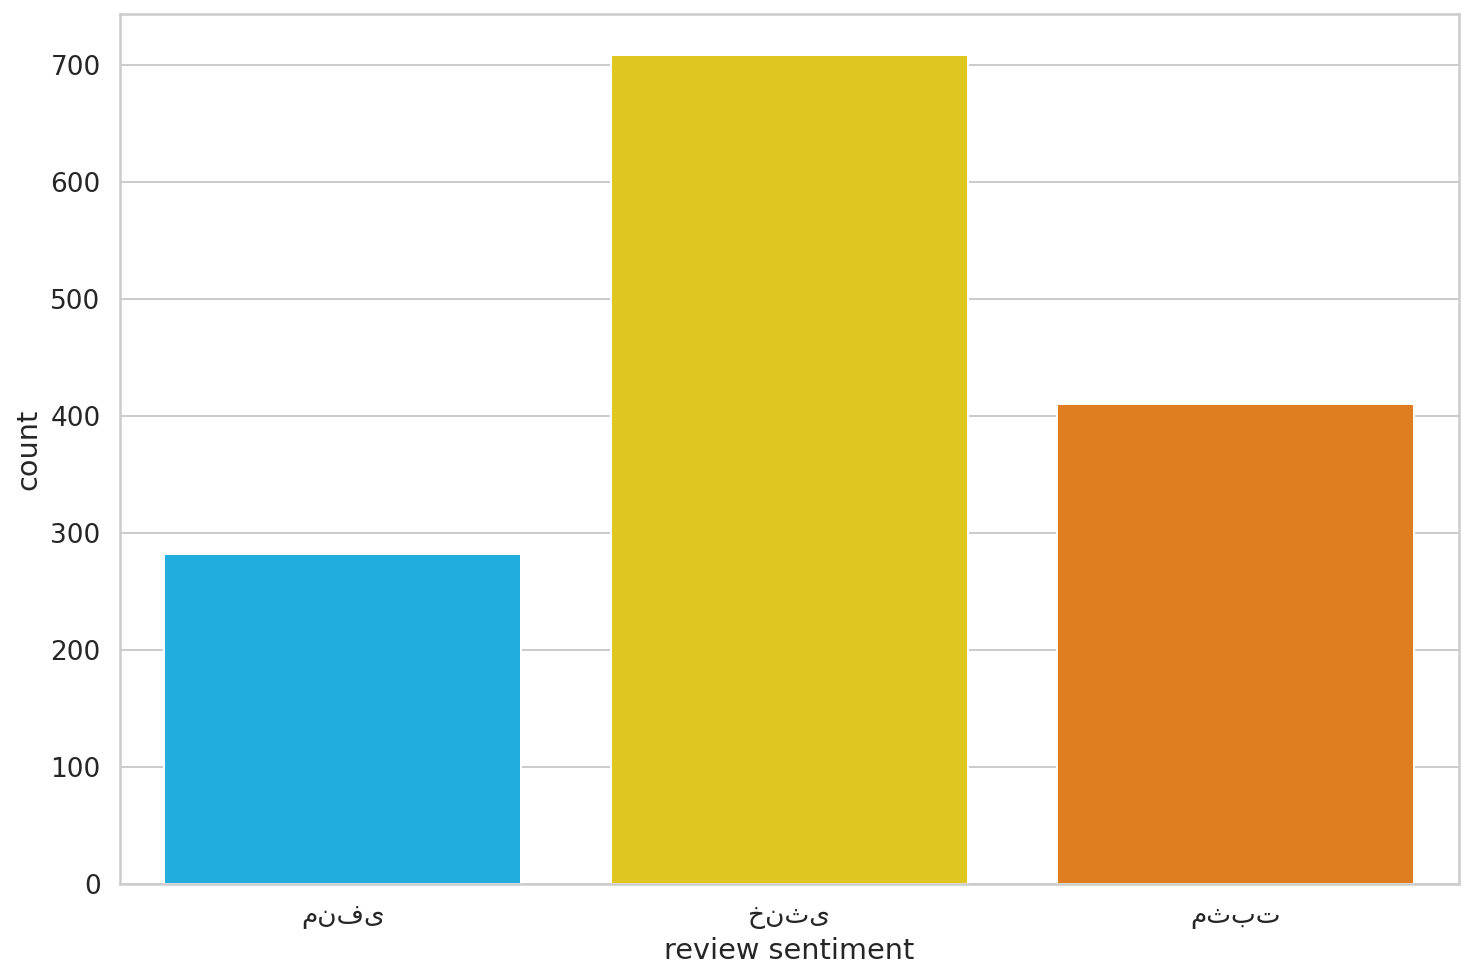

In [10]:
ax = sns.countplot(train_df.label)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [11]:
from transformers import AutoConfig, AutoTokenizer, AutoModel

config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")


Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
sample_txt = "درب اینجا به روی همه باز است."
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: درب اینجا به روی همه باز است.
   Tokens: ['درب', 'اینجا', 'به', 'روی', 'همه', 'باز', 'است', '.']
Token IDs: [8966, 4394, 2031, 2421, 2440, 2266, 2045, 15]


In [13]:
tokenizer.sep_token, tokenizer.sep_token_id


('[SEP]', 4)

In [14]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 2)

In [15]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [16]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 1)

### What ***tokenizer.encode_plus*** do

This function returns a dictionary with 2 pairs of key values.

First of all, converts each word in the *sample_txt* to the *id* of them in the corpus. and save them in the value of the ***input_ids*** key.

Then creates a list which has ones as much as the number of words at first of the list and the rest is zero (total length of the list is equal to maximum length of a sentence in the corpus), then the tensored of the list will be saved in the corresponding value of the ***attention_mask***. At this point we assume the maximum number of words in sentences in the corpus is 32, but we will find the maximum length for our dataset later.





In [17]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [18]:
print(encoding.attention_mask)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


## Finding MAX len

At first, we search through our dataset and calculate lenght of each text and save them into ***token_lens***.

Then draw a plot to see the distribution of lenghts of texts in the dataset. As it is shown, most of the texts in the dataset has a length lower than 256, so we assume the ***MAX_LEN*** is 256.

In [19]:
token_lens = []
for txt in train_df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


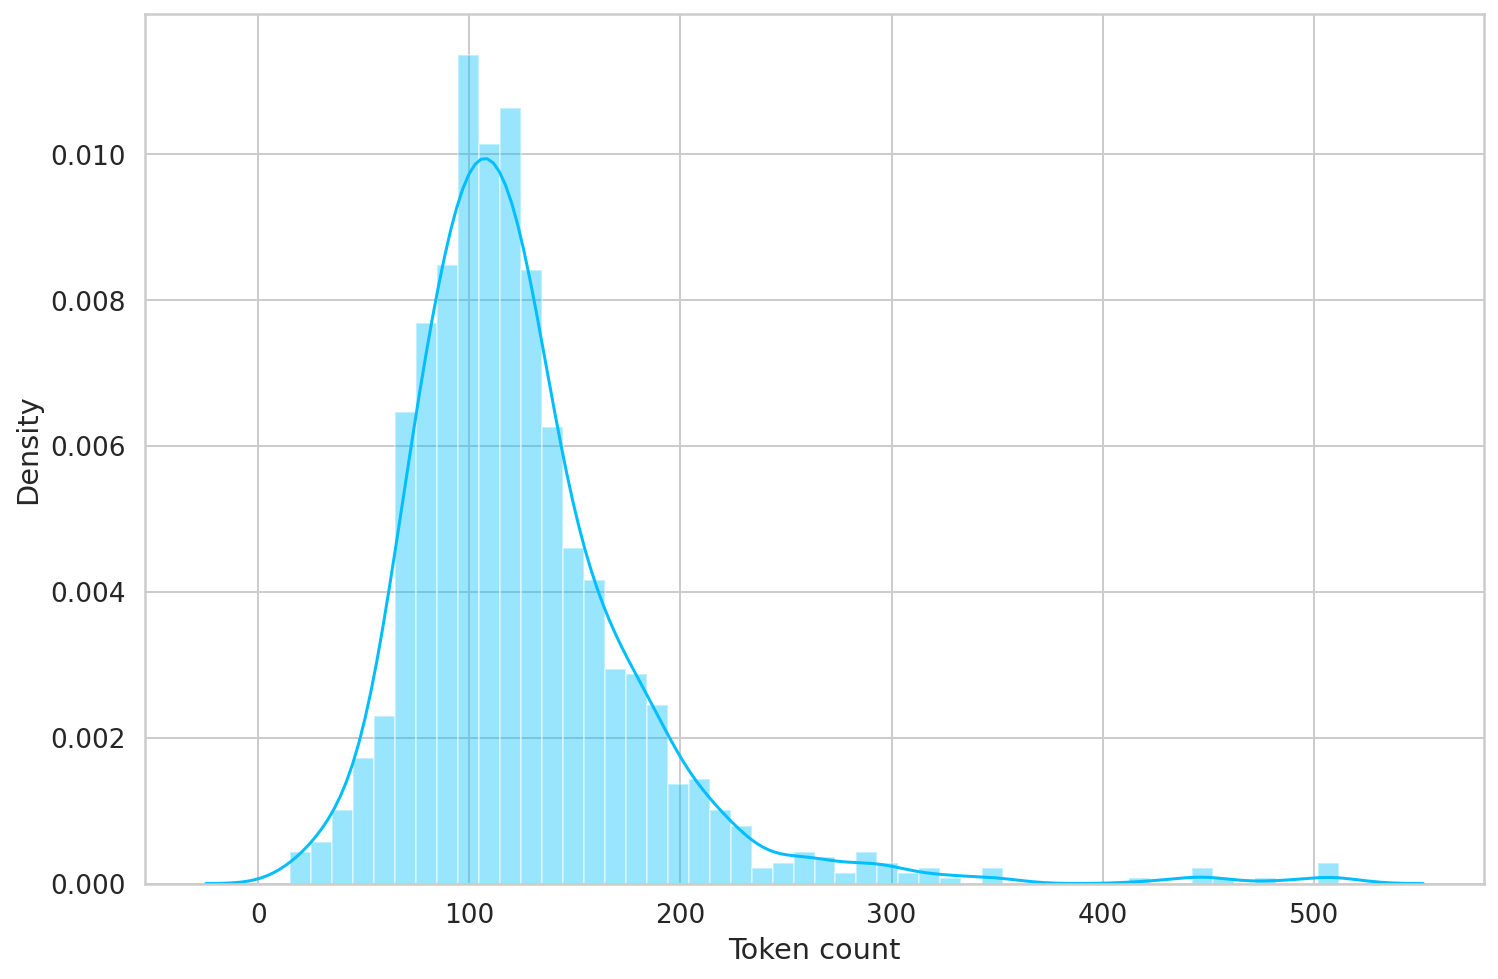

In [20]:
sns.distplot(token_lens)
plt.xlabel('Token count');

In [21]:
MAX_LEN = 256

## ***GPReviewDataset*** class

As we want to load a dataset using the *torch* library, so we a have to build a dataset which is compatible to *torch*.

So we build a customized Dataset, so called ***GPReviewDataset***, which has attributes to save *texts* and their *labels*, also a *tokenizer* to get the *input_ids* and the *attention_mask* from it, and a *max_len* attribute to use while using the *tokenizer.encode_plus*

In [22]:
class GPReviewDataset(Dataset):

  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

## ***create_data_loader*** function

Inputs: *df*: DataFrame, *tokenizer*: function, *max_len*: int, *batch_size*: int

Output: *DataLoader*

This function, creates a Dataset using *GPReviewDataset*, *df.text*, *df.label*, *tokenizer* and *max_len*, then return a *DataLoader* using the dataset, *batch_size*

In [23]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    texts=df.text.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

For each *train_df*, *eval_df*, and *test_df* we create a *DataLoader* with *batch_size* of 16. 

In [24]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(eval_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [26]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


## ***ParsBert*** Model and it's attributes

We create a model using *parsbert*, *input_ids*, and *attention_mask*.

***last_hidden_state***: The embeding of each sentence.

***pooler_output***: The output of *last_hidden_state* after applying a linear model. The final layer of the *bert* has 768 cells. The so called linear model is trained by the developers of *bert*.

Next, we're going to use this *bert* model in a Classifier.

In [27]:
model_output = model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [28]:
model_output.keys()
last_hidden_state = model_output.last_hidden_state
pooled_output = model_output.pooler_output

In [29]:
print(pooled_output.shape)
print(last_hidden_state.shape)

torch.Size([1, 768])
torch.Size([1, 32, 768])


In [30]:
model.config.hidden_size

768

## ***SentimentClassifier*** class

It is inherited from nn.Model. In the ***constructor*** of the class, we introduce the layers which are going to be used in the classifier.

For the first layer, ParsBert is used, and then a *regularization* layer which is a *DropOut*, afterwards a *linear* layer.

***forward*** function: First, the output of the *bert* model (See the previous Mark down for more information) is saved, and then the embeding which *pooler_output* returns is given to *DropOut*, and then a *linear* layer is applied to the result of the *DropOut* (by considering the number of classes) and it will be returned as the final output.

In [31]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    model_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = model_output.pooler_output
    output = self.drop(pooled_output)
    return self.out(output)

For our problem, we instiate from the above class by considering the number of class_names which is 3 in our case, and the model is set on GPU.

In [32]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


The softmax is applied to get the probability of each class. At first this probabilities are random but after it's trained it will get precise.

In [34]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4575, 0.1932, 0.3493],
        [0.4636, 0.3293, 0.2071],
        [0.5519, 0.2638, 0.1843],
        [0.4299, 0.3519, 0.2182],
        [0.6276, 0.1590, 0.2134],
        [0.5950, 0.2020, 0.2030],
        [0.5253, 0.2071, 0.2677],
        [0.4253, 0.3387, 0.2360],
        [0.3897, 0.2004, 0.4098],
        [0.4489, 0.2736, 0.2774],
        [0.5316, 0.2286, 0.2398],
        [0.4116, 0.3785, 0.2099],
        [0.3574, 0.3498, 0.2927],
        [0.5221, 0.2828, 0.1951],
        [0.6265, 0.1866, 0.1869],
        [0.6128, 0.1921, 0.1951]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## ***Training***

***AdamW*** is an optimizer which is used for transformers.

We use *CrossEntropyLoss* as the loss function because there are more than 2 classes.

In [35]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## ***train_epoch*** function

**Inputs**: model: SentimentClassifier, data_loader: DataLoader, loss_fn, optimizer, device, scheduler, n_examples
**bold text**
This function runs a single epoch in training mode.

At first, we set the *model* in the training mode.

Then by using *data_loader*, each batch is gotten, and get the ***input_ids***, ***attention_mask***, and labels from the batch.

Afterwards, a *SentimentClassifier* is used, using ***input_ids*** and ***attention_mask*** and return a single linear layer.

Then the maximum of outputs of the model is assumed as the prediction (the one with the highest probability).

Next, the ***loss*** of the predictions and the labels is calculated, and also the number of ***correct_predictions***.

The ***clip_grad_norm_*** is used to avoid gradiant explosion and vanishing.

The *optimizers*' paremeters will be updated using ***step*** function 

As the output, the percentage of ***correct_predictions*** and the mean of ***loss*** is calculated and returned.

In [36]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [37]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
# %%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train_df)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(eval_df)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 0.9347170611674135 accuracy 0.5778571428571428


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.710084068775177 accuracy 0.7222222222222222
Epoch 2/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.6114242230118676 accuracy 0.75


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6951685428619385 accuracy 0.75
Epoch 3/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.29288868057880213 accuracy 0.8928571428571429


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.9096538484096527 accuracy 0.736111111111111
Epoch 4/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.12033613189785021 accuracy 0.96


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.2921295404434203 accuracy 0.6944444444444444
Epoch 5/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.04216896267793014 accuracy 0.99


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.4754043579101563 accuracy 0.7083333333333333
Epoch 6/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.014236122442195086 accuracy 0.995


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.5263356208801269 accuracy 0.736111111111111
Epoch 7/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.004635253732306988 accuracy 0.9985714285714286


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.6476585865020752 accuracy 0.736111111111111
Epoch 8/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.0030124031122382307 accuracy 0.9992857142857143


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.6316286325454712 accuracy 0.75
Epoch 9/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.0012271211002040548 accuracy 0.9992857142857143


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.6784520149230957 accuracy 0.736111111111111
Epoch 10/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.0008856120958543298 accuracy 1.0


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.6821438074111938 accuracy 0.736111111111111


In [39]:
history['train_acc'] =  [x.cpu().data.numpy() for x in history['train_acc']]


In [40]:
history['val_acc'] =  [x.cpu().data.numpy() for x in history['val_acc']]

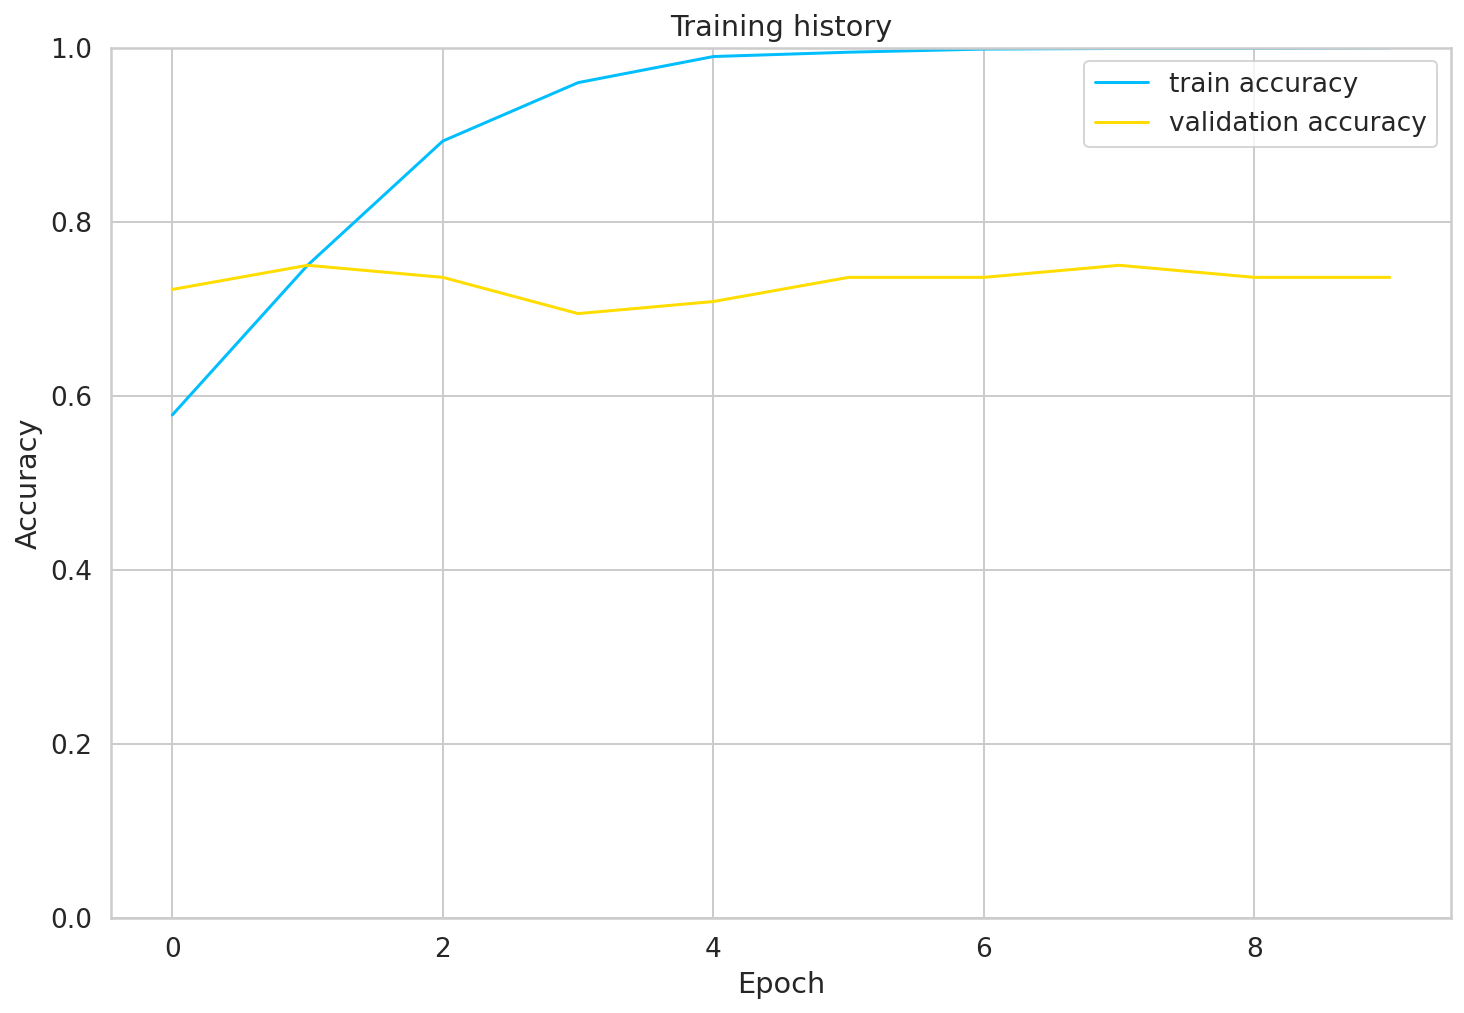

In [41]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [42]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_df)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.6527777777777778

In [43]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [44]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [45]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

        منفی       0.69      0.64      0.67        14
        خنثی       0.62      0.76      0.68        33
        مثبت       0.68      0.52      0.59        25

    accuracy                           0.65        72
   macro avg       0.67      0.64      0.65        72
weighted avg       0.66      0.65      0.65        72



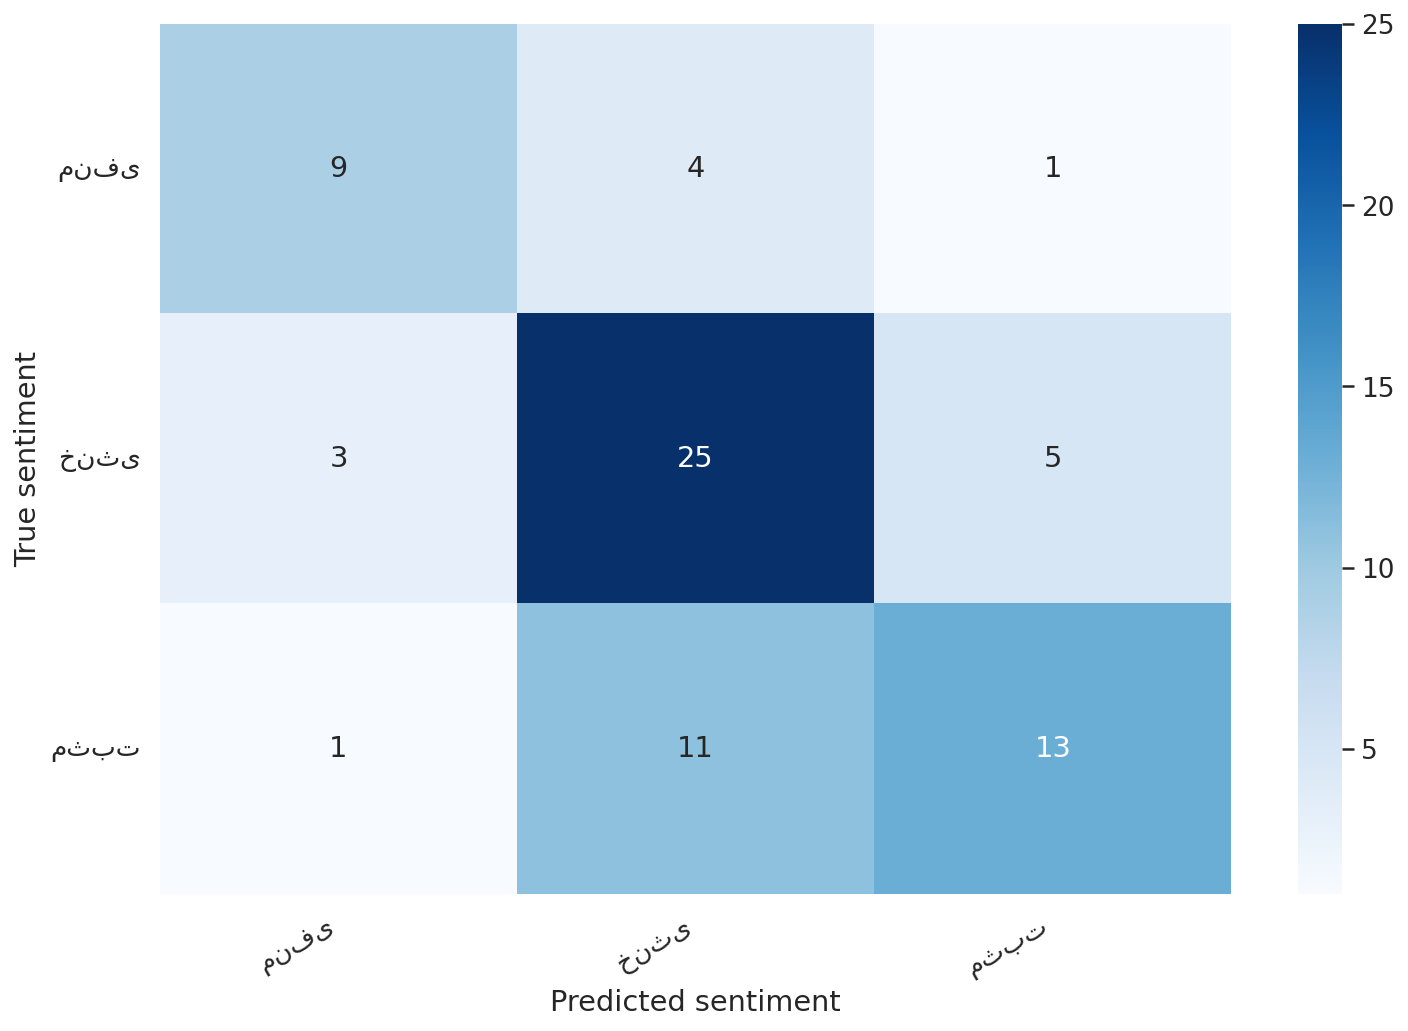

In [46]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [72]:
!cp "/content/best_model_state.bin" "/content/drive/MyDrive/Arshad/NLP/HW4"
#!cp "/content/arash_reanno.csv" "/content/drive/MyDrive/Arshad/NLP/HW4"
#!cp "/content/behdad_reanno.csv" "/content/drive/MyDrive/Arshad/NLP/HW4"

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Let's try the model

In [93]:
idx = 20

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [94]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

تداوم بی رونقی بازارهای داخلی. همراه با کاهش نرخ بازده اوراق قرضه
ایالات متحده آمریکا، طلا توانست بار دیگر صعودی شده و در روز جمعه حتی
تا نزدیکی 1780 دلار نیز صعود کرده و در نهایت، بهای هر اونس طلا در
آخرین روز معاملاتی بازار جهانی۱0 دلار و 1۰ سنت معادل 6/ 0 درصد افزایش
یافت و در ۱۷76 دلار و 9۰ سنت بسته شد که بالاترین قیمت از ۲۴ فوریه بود.
پس از اینکه قیمت طلا سطح مقاومتی مهم ۱۷۶۵ دلار را شکست و در بالاترین
حد دو ماه گذشته قرار گرفت، تحلیلگران به روند افزایشی طلا در معاملات
هفته جاری بی نهایت خوش بین شدند و بر این باورند که طلا می تواند سطح
روانی 1800 دلار را به دست آورده و صعود های بیشتری از خود نشان دهد

True sentiment: منفی


Now we can look at the confidence of each sentiment of our model:

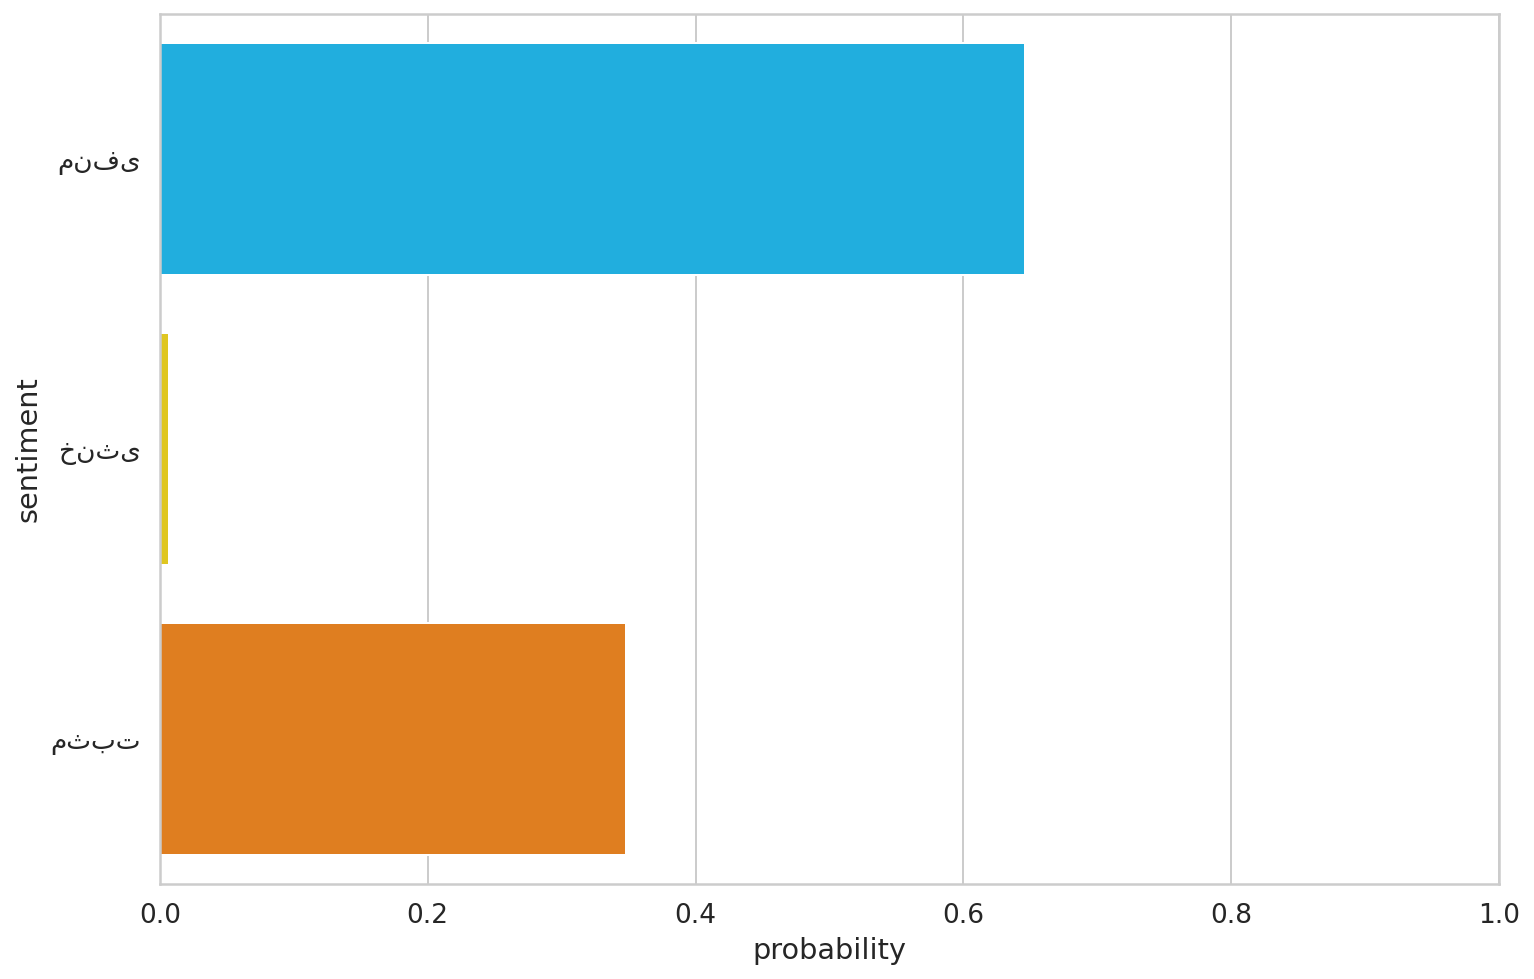

In [95]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);